In [2]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

In [3]:
import pydicom as dicom

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

In [4]:
os.chdir("G:/rsna-2023-abdominal-trauma-detection/")

In [5]:
s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in glob("./train_images/*/*")}
s_ids = s_id_p_id.keys()

p_ids = [int(s_id_p_id[x]) for x in s_ids]
p_s_df = pd.DataFrame({"series_id":s_ids,"patient_id":p_ids})
len(s_ids),len(p_s_df)

(4711, 4711)

In [6]:
train_csv = pd.read_csv(os.path.join(f'./train.csv'))
#train_csv = train_csv.sample(16).reset_index(drop=True) #if DEBUG else df
# liver, spleen, lkidney, rkidney, bowel
# train_csv["C5"] = 1-train_csv[["bowel_healthy"]]
# train_csv["C1"] = 1-train_csv[["liver_healthy"]]
# train_csv["C2"] = 1-train_csv[["spleen_healthy"]]
# train_csv["C3"] = (train_csv["kidney_low"]).astype(np.float64)*0.5 +\
#         (train_csv["kidney_high"]).astype(np.float64) 
# train_csv["C4"] = (train_csv["kidney_low"]).astype(np.float64)*0.5 +\
#         (train_csv["kidney_high"]).astype(np.float64) 
# train_csv["C5"] = (train_csv["spleen_low"]).astype(np.float64)*0.5 + \
#       (train_csv["spleen_high"]).astype(np.float64)
train_csv = train_csv.merge(p_s_df,on="patient_id",how="left")

print(train_csv.shape)

(4711, 16)


In [7]:
train_csv.columns

Index(['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury', 'series_id'],
      dtype='object')

In [8]:
sum(train_csv.bowel_healthy.values==0),sum(train_csv.bowel_healthy.values==1)


(104, 4607)

In [9]:
sum(train_csv.extravasation_healthy.values==0),sum(train_csv.extravasation_healthy.values==1)

(300, 4411)

In [10]:
sum(train_csv["bowel_injury"].values),sum(train_csv["extravasation_injury"].values),\
    sum(train_csv["liver_low"].values),sum(train_csv["liver_high"].values),\
    sum(train_csv["kidney_low"].values),sum(train_csv["kidney_high"].values), \
    sum(train_csv["spleen_low"].values),sum(train_csv["spleen_high"].values),\
  

(104, 300, 384, 91, 176, 109, 316, 229)

In [11]:
# print(list(train_csv.
# series_id.values))

In [12]:
train_csv.iloc[0].values,list(train_csv.columns),

(array([10004, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, '21057'],
       dtype=object),
 ['patient_id',
  'bowel_healthy',
  'bowel_injury',
  'extravasation_healthy',
  'extravasation_injury',
  'kidney_healthy',
  'kidney_low',
  'kidney_high',
  'liver_healthy',
  'liver_low',
  'liver_high',
  'spleen_healthy',
  'spleen_low',
  'spleen_high',
  'any_injury',
  'series_id'])

In [13]:
df = train_csv.reset_index(drop=True)

In [14]:
for target_col in ["liver_healthy","liver_low","liver_high","bowel_healthy","bowel_injury",\
        "spleen_healthy","spleen_low","spleen_high","kidney_healthy","kidney_low","kidney_high"]:
    print(target_col,len(train_csv[train_csv[target_col]==1]))

liver_healthy 4236
liver_low 384
liver_high 91
bowel_healthy 4607
bowel_injury 104
spleen_healthy 4166
spleen_low 316
spleen_high 229
kidney_healthy 4426
kidney_low 176
kidney_high 109


In [54]:
# submission = pd.read_csv("sample_submission.csv")
# submission[["liver_low","liver_high"]] =df[["liver_low","liver_high"]].mean().to_list()

In [55]:
# all_data = []
# for idx, row in tqdm(train_csv.iterrows()):
#     dcm_files = glob(f"./train_images/{row.patient_id}/{row.series_id}/*.dcm")
#     dcm_ids = sorted([int(x.split("\\")[-1].split(".")[0]) for x in dcm_files])
#     for ii in dcm_ids:
#         img_path = f"./train_images/{row.patient_id}/{row.series_id}/{ii}.dcm"
#         all_data.append(list(row.values)+[ii,img_path])
# len(all_data)

In [56]:
# if os.path.exists(f"cropped_train_{org_name}{folder}.csv"):
#     df = pd.read_csv(f"cropped_train_{org_name}{folder}.csv")
# else:
#     print("create new df")
#     df = pd.DataFrame(columns=(list(train_csv.columns)+["path"]))
# print("before update", len(df),len(np.unique(df.series_id.values)))


In [15]:
os.getcwd(),len(train_csv)


('G:\\rsna-2023-abdominal-trauma-detection', 4711)

In [16]:
# for idx, row in tqdm(train_csv.iloc[0:1500].iterrows()):
#     if int(row["series_id"]) in df.series_id.values:
#         # print("skipping", row.patient_id, row.series_id)
#         continue
#     dcm_files = []
#     for seg_cl in seg_cls:
#         dcm_files += glob(f"G:/rsna-2023-abdominal-trauma-detection/cropped_images{folder}/{row.patient_id}_{row.series_id}_{seg_cl}_*.jpeg")
#     if len(dcm_files) == 0: continue
#     dcm_files = sorted(dcm_files ,key=lambda x:int(x.split(".")[0].split("_")[-1]))
#     # print(dcm_files)
#     added_df = pd.concat([train_csv.loc[idx:idx]]*len(dcm_files),axis=0)
#     added_df["path"] = dcm_files
#     added_df.series_id = added_df.series_id.apply(lambda x:int(x))
#     df = pd.concat([df,added_df],axis=0)
#     df = df.reset_index(drop=True)
#     df.to_csv(f"cropped_train_{org_name}{folder}1.csv",index=None)
    
# print("after update", len(df),len(np.unique(df.series_id.values)))

In [17]:
# df.to_csv(f"cropped_train_{org_name}{folder}.csv",index=None)

In [163]:
# added_df.columns, df.columns

In [164]:
# all_data = []
# for idx, row in tqdm(train_csv.iterrows()):
#     dcm_files = glob(f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{row.patient_id}/{row.series_id}/*.jpeg")
#     dcm_ids = sorted([int(x.split("\\")[-1].split(".")[0]) for x in dcm_files])
#     for ii in dcm_ids:
#         img_path = f"G:/rsna-abdominal-2023/reduced_512_tickness_5/{row.patient_id}/{row.series_id}/{ii}.jpeg"
#         all_data.append(list(row.values)+[ii,img_path])
# len(all_data)
# df = pd.DataFrame(all_data)
# df.columns = list(train_csv.columns) + ["dcm_id", "path"]


In [165]:
# cv2.imread(df.iloc[300000].path).shape

In [166]:
# df[df.fold!=0]["series_id"].values,df[df.fold!=0]["patient_id"].values

In [167]:
# [x for x in np.unique(trn_df["patient_id"].values) if x in np.unique(val_df["patient_id"].values)]

In [168]:
# trn_df = trn_df.set_index("patient_id")

In [169]:
# trn_df.loc[36414].kidney_low
# trn_df.loc[28976].kidney_low
# trn_df[trn_df.kidney_low==1]

In [18]:
import pandas as pd
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact
import matplotlib.animation as animation
from IPython.display import HTML

import pydicom
import nibabel as nib

import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
import torchvision.transforms as transforms

DATA_PATH = './rsna-2023-abdominal-trauma-detection/'
import os
os.chdir("G:/rsna-2023-abdominal-trauma-detection/")

In [19]:
len(glob('G:/rsna-abdominal-2023/reduced_512_tickness_5/[0-9]*'))

3147

In [22]:
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

# Define the transform
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.RandomVerticalFlip(0.5),  # Resize the image to 224x224 pixels
    transforms.RandomHorizontalFlip(0.5),  # Resize the image to 224x224 pixels
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])


In [23]:
class RSNADataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        sid = self.img_path[index].split("\\")[-1].split('_')[-3]
        row = df[df.series_id==str(sid)].iloc[0]
        # print(s_id_p_id[str(sid)],sid,self.img_path[index])
        # img = load_dicom(row.path)
        # print(row.path)
        # img = cv2.imread(row.path)
        # img_tmp = img[:,:,1]
        # imgs = []
        # for iid in range(len(images_coords)):
        # img_tmp = img_tmp[images_coords[0]:images_coords[0]+224,images_coords[1]:images_coords[1]+224]

        # img_tmp = torch.tensor(img_tmp.astype(np.float32)).to(torch.float32)
        # img_tmp = torch.unsqueeze(img_tmp,0)
        # img_tmp = self.transform(Image.open(row.path))
        # print(img_tmp.shape, img_tmp.max(),img_tmp.min())
        #     imgs.append(img_tmp)
        # print(img.shape,img.max(),img.min(),img.dtype)
        # print(torch.tensor([row[f"{target_col}"]]))
        img = np.array((Image.open(self.img_path[index])))
        # print(img.shape,self.img_path[index])
        # print(img.shape)
        #print(trn_df.loc[pid])
        # print(row[target_cols].values)
        # print(torch.from_numpy(row[target_cols].values.astype(np.float32)).to(torch.float32).shape)
        return torch.from_numpy(img[:,:,1:].transpose(2,0,1).astype(np.float32)), \
            torch.from_numpy(row[target_cols].values.astype(np.float32)).to(torch.float32) ,self.img_path[index],target_cols
        # torch.tensor([row[f"{target_col}"]]).to(torch.float32)
    def __len__(self):
        return len(self.img_path)


In [19]:
# np.mean(show_dataset[data_id][0][1][show_dataset[data_id][0][1]>0])
# np.unique(show_dataset[data_id][0][1][show_dataset[data_id][0][1]>0],return_counts=True)

In [24]:
from datetime import datetime

test_input = []
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target,_,_) in enumerate(train_loader):
        if i %50 == 0 and i !=0:
            print(datetime.now(), i, len(train_loader), train_loss / i)
            print(input.shape, target.shape)
            fw = open(log_path,"a")
            fw.write(" ".join([str(x) for x in ["train", datetime.now(), i, len(train_loader), train_loss / i,"\n"]]))
            fw.close()
        if len(test_input)<20: test_input.append(input)
        input = input.cuda()
        target = target.cuda()

        # print(input.shape, target.shape)
        # compute output
        output = model(input)
        # print(output.shape, target.shape)
        loss = criterion(output, target)
        if i%log_freq ==0: 
            print("log freq", log_freq,torch.sigmoid(output),target)
            fw = open(log_data_path,'a+')
            fw.write(" ".join([str(x) for x in ["freq", log_freq,datetime.now(),torch.sigmoid(output).data.cpu(), target,"\n"]]))
            fw.close()
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print("trainged")
        train_loss += loss.item()
    
    fw = open(log_path,"a")
    fw.write("end epoch\n")
    fw.close()
    fw = open(log_data_path,'a+')
    fw.write("end epoch\n")
    fw.close()
    return train_loss/len(train_loader)

def validate(val_loader, model, criterion):
    model.train()
    val_loss = 0.0
    
    val_pred = []
    val_label = []
    with torch.no_grad():
        for i, (input, target,_,_) in enumerate(val_loader):
            input = input /255.0
            if i %100 == 0 and i !=0:
                print(i, len(val_loader), val_loss / i)
                print(input.shape, input.max(), (input*255.0).max())
                fw = open(log_path,"a")
                fw.write(" ".join([str(x) for x in ["valid", datetime.now(), i, len(val_loader), val_loss / i,"\n"]]))
                fw.close()
            
            input = input.cuda()
            target = target.cuda()
            output = torch.sigmoid(model(input))
            # print("devices", output,target,criterion.weight,)
            val_loss += criterion(output, target)
            if i%log_freq ==0: 
                print("log freq", log_freq,output, target)
                fw = open(log_data_path,'a+')
                fw.write(" ".join([str(x) for x in ["valid freq",datetime.now(), log_freq,output.data.cpu(), target,"\n"]]))
                fw.close()
            
            val_pred.append(output.data.cpu().numpy())
            val_label.append(target.data.cpu().numpy())
    return val_loss / len(val_loader.dataset), val_pred, val_label


In [21]:
# = glob("./224files/*.jpeg")

In [54]:
pids = list(train_csv.index)


In [55]:
torch.zeros((2,1,224,224)).shape

torch.Size([2, 1, 224, 224])

In [23]:
# img_tmp = torch.tensor(np.zeros((1,224,224)).astype(np.float32)).to(torch.float32)
# model(torch.stack([torch.unsqueeze(img_tmp,0)],0).cuda()).shape,\
# model(torch.stack([torch.zeros(1,224,224)],0).to("cuda")).shape
# model(torch.stack([],0).to("cuda")).shape
# np.mean(np.array([]),axis=0)

tensor([1., 0., 0.]) ./cropped_organs\7358_7032_1_97.jpeg ['liver_healthy', 'liver_low', 'liver_high']
tensor([1., 0., 0.]) ./cropped_organs\46325_15753_1_33.jpeg ['liver_healthy', 'liver_low', 'liver_high']


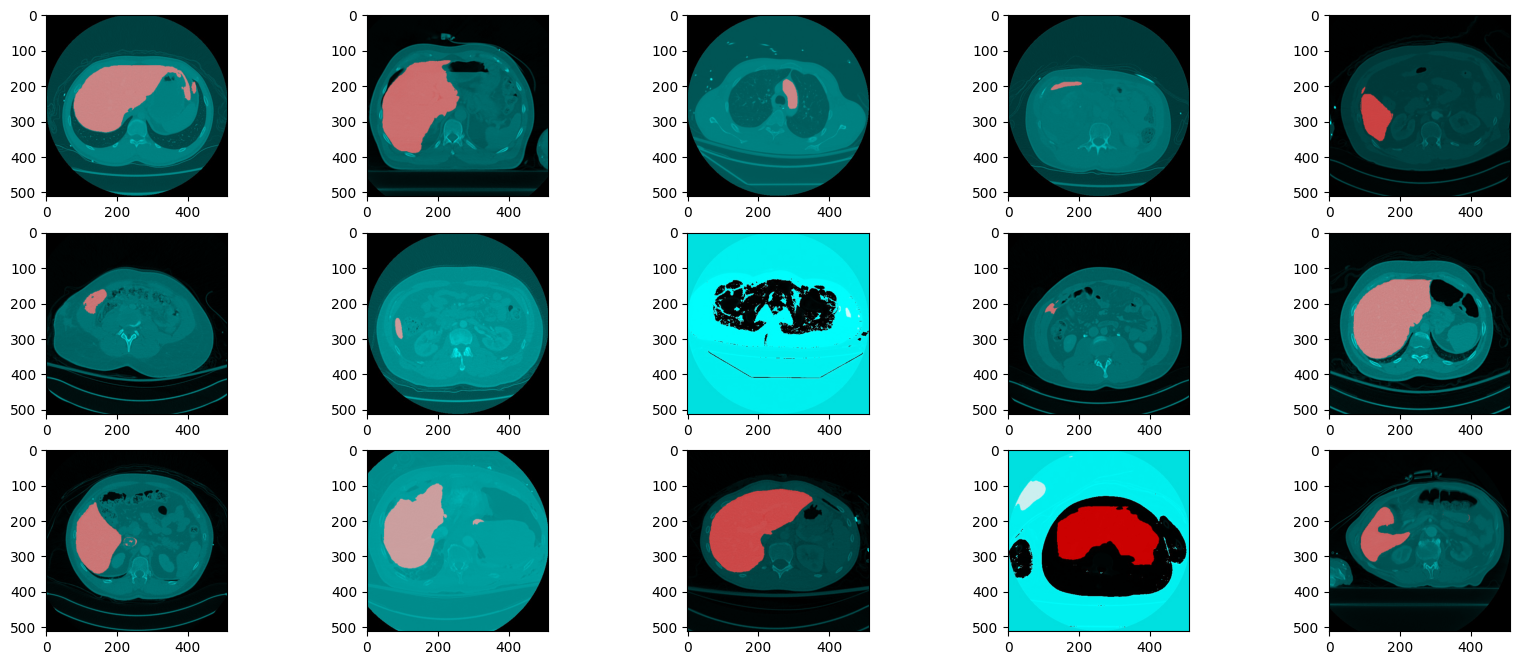

In [30]:
show_dataset = RSNADataset(trn_files)
for ii in range(15):
    show_data = show_dataset[np.random.randint(len(show_dataset))]
    if(ii<2):print(show_data[1],show_data[2],show_data[3])
    show_img = show_data[0][0]
    show_mask = show_data[0][1]
    plt.subplot(3,5,ii+1);plt.imshow(np.stack([show_mask,show_img,show_img],axis=2).astype(np.int32))

In [25]:
target_cols = ["kidney_low","kidney_high"]
target_cols = ["kidney_healthy","kidney_low","kidney_high"]
# target_cols = ["bowel_healthy","bowel_injury","extravasation_healthy","extravasation_injury"]
# target_cols = ["spleen_healthy","spleen_low","spleen_high"]
# target_cols = ["spleen_low","spleen_high"]

target_cols = ["liver_healthy","liver_low","liver_high"]
# target_cols = ["liver_low","liver_high"]
images_coords = [239-112, 180-112]
# org_name = "kidney"
# org_name = "rkidney"
org_name = "liver"

# org_name = "bowel"
# org_name = "spleen"
ratio = 6
version = f"1013bal_{ratio}"
folder = "cropped_organs_sid/"
seg_cls = ["3","4"]
model_name = "resnet"
seg_cls = ["1"]
# seg_cls = ["2"]
# seg_cls = ["4"]
# seg_cls = ["5"]
model_path = f'./models/single/{model_name}_{org_name}_ep{0}_fold{0}_{len(target_cols)}labels_{version}.pth'
log_path = model_path.replace(".pth",".txt")
if not os.path.exists(log_path):
    fw = open(log_path,"w")
    fw.close()
    
if not os.path.exists(log_path.replace(".txt","")+"data.txt"):
    fw = open(log_path.replace(".txt","")+"data.txt","w")
    fw.close()

print(org_name,version,folder,seg_cls,model_name,target_cols,model_path)

liver 1013bal_6 cropped_organs_sid/ ['1'] resnet ['liver_healthy', 'liver_low', 'liver_high'] ./models/single/resnet_liver_ep0_fold0_3labels_1013bal_6.pth


In [26]:
# total_files = glob(f"./cropped_organs/*.jpeg")
# print("total files", len(total_files))

seg_files = [x for x in total_files if x.split("_")[-2] in seg_cls[0]]
print("total seg files",seg_cls,len(seg_files),"sids",\
      np.array(seg_files)[np.random.choice(len(seg_files),7)], np.unique([x.split("_")[-3] for x in seg_files]))


total files 3445707
total seg files ['1'] 706137 sids ['./cropped_organs\\12600_3309_1_131.jpeg'
 './cropped_organs\\32154_59584_1_84.jpeg'
 './cropped_organs\\23198_43260_1_468.jpeg'
 './cropped_organs\\37273_31602_1_204.jpeg'
 './cropped_organs\\38386_58479_1_478.jpeg'
 './cropped_organs\\10104_27573_1_115.jpeg'
 './cropped_organs\\34869_35546_1_94.jpeg'] ['10000' '10006' '10007' ... '9987' '999' '9999']


In [27]:
xx = np.array([[1,5,9],[3,2,2]]).transpose()
xx / np.sum(xx,axis=0)

array([[0.06666667, 0.42857143],
       [0.33333333, 0.28571429],
       [0.6       , 0.28571429]])

In [27]:
# from sklearn.model_selection import KFold, GroupKFold
# train_df = train_csv
# gkf = KFold(n_splits=4)
# for i, (train_index, val_index) in enumerate(gkf.split(train_df, groups=train_df["patient_id"])):
#     train_df.loc[val_index,"fold"]=i
# train_df.to_csv(f'./models/single/train_valid_split1009.csv')
# csv_f = f'./models/resnet18LSTM/resnet18_{organ_name}_{VOLUME[0]}_{VOLUME[1]}_{VOLUME[2]}_{len(TARGET_COLS)}labels_{version}.csv'
# print("reading", csv_f)
train_df = pd.read_csv(f'./models/single/train_valid_split1009.csv')
val_df = train_df[train_df.fold==0].reset_index(drop=True)
trn_df = train_df[train_df.fold!=0].reset_index(drop=True)
len(np.unique(val_df.patient_id.values))+len(np.unique(trn_df.patient_id.values)), \
len(np.unique(val_df.series_id.values))+len(np.unique(trn_df.series_id.values))
trn_df = train_df

In [28]:
df_to_split =trn_df
if org_name =="bowel":
    neg_df = pd.concat([df_to_split[df_to_split[target_cols[1]]==1],df_to_split[df_to_split[target_cols[3]]==1]],axis=0) # for liver, spleen, kidney
    print("negative",len(neg_df),target_cols[1],np.sum(neg_df[target_cols[1]]),target_cols[3], np.sum(neg_df[target_cols[3]]))
elif len(target_cols)==3:
    neg_df = pd.concat([df_to_split[df_to_split[target_cols[2]]==1],df_to_split[df_to_split[target_cols[1]]==1]],axis=0) # for bowel
    print("negative",len(neg_df),target_cols[1],np.sum(neg_df[target_cols[1]]),target_cols[2], np.sum(neg_df[target_cols[2]]))
elif len(target_cols)==2:
    print("non bowel label 2")
    neg_df = pd.concat([df_to_split[df_to_split[target_cols[0]]==1],df_to_split[df_to_split[target_cols[1]]==1]],axis=0) # for bowel
    print("negative",len(neg_df),target_cols[1],np.sum(neg_df[target_cols[1]]),target_cols[0], np.sum(neg_df[target_cols[0]]))
neg_trn_df = neg_df
pos_trn_df = df_to_split[~df_to_split.series_id.isin(neg_trn_df.series_id.values)]
print("positive", len(pos_trn_df),np.sum(pos_trn_df[target_cols[1]])+np.sum(pos_trn_df[target_cols[2]]))
# pos_trn_df = pos_trn_df.iloc[(np.random.choice(len(pos_trn_df),ratio*len(neg_trn_df)))]
# bal_trn_df = pd.concat([pos_trn_df,neg_trn_df],axis=0)
# print("bal shape",bal_trn_df.shape)

df_to_split =val_df
if org_name =="bowel":
    neg_df = pd.concat([df_to_split[df_to_split[target_cols[1]]==1],df_to_split[df_to_split[target_cols[3]]==1]],axis=0) # for liver, spleen, kidney
    print("negative",len(neg_df),target_cols[1],np.sum(neg_df[target_cols[1]]),target_cols[3], np.sum(neg_df[target_cols[3]]))
elif len(target_cols)==3:
    neg_df = pd.concat([df_to_split[df_to_split[target_cols[2]]==1],df_to_split[df_to_split[target_cols[1]]==1]],axis=0) # for bowel
    print(target_cols, "negative",len(neg_df),target_cols[1],np.sum(neg_df[target_cols[1]]),target_cols[2], np.sum(neg_df[target_cols[2]]))
elif len(target_cols)==2:
    print(target_cols, "label 2")
    neg_df = pd.concat([df_to_split[df_to_split[target_cols[0]]==1],df_to_split[df_to_split[target_cols[1]]==1]],axis=0) # for bowel
    print("negative",len(neg_df),target_cols[1],np.sum(neg_df[target_cols[1]]),target_cols[0], np.sum(neg_df[target_cols[0]]))
pos_val_df = df_to_split[~df_to_split.series_id.isin(neg_df.series_id.values)]
# bal_trn_df.shape
pos_val_df = pos_val_df.iloc[(np.random.choice(len(pos_val_df),ratio*len(neg_df)))]
bal_val_df = pd.concat([pos_val_df,neg_df],axis=0)


negative 475 liver_low 384 liver_high 91
positive 4236 0
['liver_healthy', 'liver_low', 'liver_high'] negative 123 liver_low 94 liver_high 29


In [30]:
# trn_df

In [29]:
print("column, bal_trn_col, bal_trn, val_df_col, val_df, bal_val_df_col, bal_val_df")
for col in target_cols:
    print(col, np.sum(pos_trn_df[col].values),len(pos_trn_df),np.sum(neg_trn_df[col].values),len(neg_trn_df))#
print("column, bal_val_col, bal_val, val_df_col, val_df, bal_val_df_col, bal_val_df")
for col in target_cols:
    print(col, np.sum(val_df[col].values),len(val_df))#,np.sum(bal_val_df[col].values),len(bal_val_df))

trn_files = [seg_file for seg_file in seg_files if int(seg_file.split("_")[-3]) in neg_trn_df["series_id"].values]
pos_trn_files = [seg_file for seg_file in seg_files if int(seg_file.split("_")[-3]) in pos_trn_df["series_id"].values]
print("seg files", len(seg_files),"neg trn files", len(trn_files), "pos trn files", len(pos_trn_files))
trn_files = trn_files + pos_trn_files[::4]
print(trn_files[:3], "train", len(trn_files))#,"val", len(val_files), )


val_files = []
val_files = [seg_file for seg_file in seg_files if int(seg_file.split("_")[-3]) in val_df["series_id"].values]
print(val_files[:3],len(seg_files), "val", len(val_files))#,"val", len(val_files), )

column, bal_trn_col, bal_trn, val_df_col, val_df, bal_val_df_col, bal_val_df
liver_healthy 4236 4236 0 475
liver_low 0 4236 384 475
liver_high 0 4236 91 475
column, bal_val_col, bal_val, val_df_col, val_df, bal_val_df_col, bal_val_df
liver_healthy 1055 1178
liver_low 94 1178
liver_high 29 1178
seg files 706137 neg trn files 71313 pos trn files 634824
['./cropped_organs\\10163_17557_1_100.jpeg', './cropped_organs\\10163_17557_1_101.jpeg', './cropped_organs\\10163_17557_1_102.jpeg'] train 230019
['./cropped_organs\\10004_21057_1_342.jpeg', './cropped_organs\\10004_21057_1_343.jpeg', './cropped_organs\\10004_21057_1_344.jpeg'] 706137 val 172529


In [77]:
# trn_df = trn_df.drop(columns=["Unnamed: 0"])

pos_weights = {"kidney":[1,4,8],"bowel":[1,4,1,4],"liver":[1,2,4],"spleen":[2,4],\
                "lkidney":[1,4,6],"rkidney":[1,2],"all":[1,2,1,6,1,2,4,1,2,4,1,2,4]}
pos_weight = torch.Tensor(pos_weights[org_name]).cuda()#([1,2,1,6,1,2,4,1,2,4,1,2,4,6]).cuda()
criterion = nn.BCEWithLogitsLoss(pos_weight)#pos_weight=pos_weight)
# optimizer = torch.optim.SGD(model.parameters(), 0.0001)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = torch.FloatTensor(alpha)
        self.gamma = gamma

    def forward(self, inputs, targets):

        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        print("input and target", inputs,targets)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

# class FocalLoss(nn.Module):
#     '''
#     Multi-class Focal loss implementation
#     '''
#     def __init__(self, gamma=2, weight=None):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.weight = torch.FloatTensor(weight)

#     def forward(self, input, target):
#         """
#         input: [N, C]
#         target: [N, ]
#         """
#         logpt = F.log_softmax(input, dim=1)
#         pt = torch.exp(logpt)
#         logpt = (1-pt)**self.gamma * logpt
#         print("logpt", logpt)
#         loss = F.nll_loss(logpt, target, self.weight)
#         return loss

class FocalLoss(nn.Module):

    def __init__(self, weight=None, reduction='mean', gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(weight))
        # self.ce = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor(weight))

    def forward(self, input, target):
        logp = self.ce(input, target)
        print("logp", logp)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

logits = torch.Tensor([[0,0],[0,0],[0,0],[.5,.5],[1,0],[0,0],[0,0]])
targets = torch.Tensor([[0,0],[0,0],[0,0],[1,0],[0,0],[0,0],[0,0]])
# logits = torch.Tensor([0,1])
weight = torch.Tensor([1,4])
# F.binary_cross_entropy_with_logits(logits,targets)
# FocalLoss(weight=[1,4])(logits,targets)
torch.nn.CrossEntropyLoss()(logits, targets)
torch.nn.BCEWithLogitsLoss(pos_weight=weight)(logits, targets)
# criterion = FocalLoss(alpha=[1,10],gamma=2)


tensor(0.7419)

In [66]:
torch.sigmoid(torch.FloatTensor([0.05]))

tensor([0.5125])

In [67]:
torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1,1]))(logits[2:],targets[2:])

tensor(0.1386)

In [26]:
best_loss = 100
model_name = "resnet"

log_freq = 40
for fold in range(1):
    # bowel_healthy, bowel_injury, extravasaton_healthy, extravasaton_injury, 
    # kidney_healthy, kidney_low, kidney_high, 
    # liver_healthry, liver_low, liver_high, 
    # spleen_healthy, spleen_low, spleen_high, 
    # model = model.cuda()
    # pos_weight = torch.Tensor([1,2,1,6,1,2,4,1,2,4,1,2,4,6]).cuda()
    # start_epoch = 0
    pos_weights = {"kidney":[1,4,8],"bowel":[1,4,1,4],"liver":[1,4,6],"spleen":[1,3,4],\
                    "lkidney":[1,4,6],"rkidney":[1,4,6],"all":[1,2,1,6,1,2,4,1,2,4,1,2,4]}
    pos_weight = torch.Tensor(pos_weights[org_name]).cuda()#([1,2,1,6,1,2,4,1,2,4,1,2,4,6]).cuda()
    criterion = nn.BCEWithLogitsLoss(pos_weight)#pos_weight=pos_weight)
    # pos_trn_df = pos_df.iloc[(np.random.choice(len(pos_df),len(neg_df)))]
    # bal_trn_df = pd.concat([pos_trn_df,neg_df],axis=0)
    print("column, bal_trn_col, bal_trn, val_df_col, val_df, bal_val_df_col, bal_val_df")
    for col in target_cols:
        print(col, np.sum(trn_df[col].values),len(trn_df),np.sum(val_df[col].values),len(val_df))
    model = torchvision.models.resnet34(True)
    model.fc = torch.nn.Linear(512, 3)
    model.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model = model.cuda()
    log_path = model_path.replace(".pth",".txt")
    log_data_path = model_path.replace(".pth", "data.txt")
    optimizer = torch.optim.SGD(model.parameters(), 0.0004)
    # model.load_state_dict(torch.load(f'./models/single/resnet_liver_ep0_fold0_3labels_1009_balv2.pth', map_location=torch.device('cpu')))
    # print(model.load_state_dict(torch.load(f'./models/single/resnet_spleen_ep0_fold0_2labels_1009_balv2.pth', map_location=torch.device('cpu'))))
    # trn_files = []
    # trn_files = [seg_file for seg_file in seg_files if int(seg_file.split("_")[-3]) in bal_trn_df["series_id"].values]
    print(RSNADataset(trn_files, None)[0][2:])
    train_loader = torch.utils.data.DataLoader(
        RSNADataset(trn_files, None), 
        batch_size=6, shuffle=True, num_workers=0, pin_memory=False
    )
    print(model_path, log_path)
    for epoch in range(0,2):
        # pos_trn_df = pos_df.iloc[np.random.choice(len(pos_df),len(neg_df))]

        # trn_df = pd.concat([neg_df,pos_trn_df],axis=0).reset_index(drop=True)
        # print(trn_df.shape, "positive", len(pos_trn_df),np.sum(pos_df[target_cols[0]])+np.sum(pos_df[target_cols[1]]))
        # trn_df.to_csv(f'./models/single/{model_name}_{org_name}_ep{epoch}_{len(target_cols)}labels_{version}_bal.csv')

        train_loss = train(train_loader, model, criterion, optimizer)
        torch.cuda.empty_cache()

        torch.save(model.state_dict(), model_path)


column, bal_trn_col, bal_trn, val_df_col, val_df, bal_val_df_col, bal_val_df
liver_healthy 4236 4711 1055 1178
liver_low 384 4711 94 1178
liver_high 91 4711 29 1178
('./cropped_organs\\10163_17557_1_100.jpeg', ['liver_healthy', 'liver_low', 'liver_high'])
./models/single/resnet_liver_ep0_fold0_3labels_1013bal_6.pth ./models/single/resnet_liver_ep0_fold0_3labels_1013bal_6.txt
log freq 40 tensor([[0.3856, 0.5331, 0.6966],
        [0.3745, 0.5468, 0.6340],
        [0.3782, 0.5680, 0.6718],
        [0.2627, 0.6396, 0.6459],
        [0.3468, 0.6310, 0.7268],
        [0.3414, 0.5307, 0.7443]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]], device='cuda:0')
log freq 40 tensor([[0.5127, 0.2648, 0.1442],
        [0.3682, 0.3222, 0.1447],
        [0.5096, 0.1728, 0.1307],
        [0.5398, 0.2212, 0.1388],
        [0.5785, 0.1716, 0.1121],
        [0.5265, 0.3092, 0.1

KeyboardInterrupt: 

In [99]:
torch.save(model.state_dict(), model_path)

In [27]:
model_path

'./models/single/resnet_liver_ep0_fold0_3labels_1013bal_6.pth'

In [ ]:
model_path

'./models/single/resnet_liver_ep0_fold0_3labels_1009_balv2.pth'

In [ ]:
del train_loader

In [ ]:
len(np.unique([x.split("_")[-3] for x in seg_files]))

4710

In [ ]:
np.random.choice(trn_files,5)

array(['./cropped_organs\\54190_59346_3_267.jpeg',
       './cropped_organs\\43342_64389_3_63.jpeg',
       './cropped_organs\\26510_46157_3_159.jpeg',
       './cropped_organs\\61547_62573_4_183.jpeg',
       './cropped_organs\\38238_20684_3_485.jpeg'], dtype='<U40')

In [ ]:
len(val_files),len(trn_files)

(12211, 71809)

In [ ]:
torch.cuda.empty_cache()

In [68]:
np.stack([[1,1],[2,2]],axis=1)

array([[1, 2],
       [1, 2]])

In [36]:
print("column, bal_val_col, bal_val, val_df_col, val_df, bal_val_df_col, bal_val_df")
target_cols = ["liver_healthy","liver_low","liver_high"]
seg_cls = ["1"]
for col in target_cols:
    print(col, np.sum(bal_val_df[col].values),len(bal_val_df),np.sum(val_df[col].values),len(val_df))

seg_files = [x for x in total_files if x.split("_")[-2]==seg_cls[0]]
print("total seg files",seg_cls,len(seg_files),"sids",\
      np.array(seg_files)[np.random.choice(len(seg_files),7)], np.unique([x.split("_")[-3] for x in seg_files]))

val_files = []
val_files = [seg_file for seg_file in seg_files if int(seg_file.split("_")[-3]) in val_df["series_id"].values]
print(val_files[:3],len(seg_files), "train", len(val_files))

print("check dataset", RSNADataset(val_files, None)[0])

val_loader = torch.utils.data.DataLoader(
RSNADataset(trn_files, None), 
batch_size=6, shuffle=True, num_workers=0, pin_memory=False
)
model = torchvision.models.resnet34(True)
model.fc = torch.nn.Linear(512, 3)
model.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_path = "./models/single/resnet_liver_ep0_fold0_3labels_1012bal2.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
log_path = model_path.replace(".pth", "val.txt")
log_data_path = model_path.replace(".pth", "valdata.txt")

log_freq =5
model = model.cuda()
criterion = nn.BCEWithLogitsLoss(torch.Tensor([1,2,4]).cuda())
liver_val_loss, liver_val_pred, liver_val_label = validate(val_loader, model, criterion)


column, bal_val_col, bal_val, val_df_col, val_df, bal_val_df_col, bal_val_df
liver_healthy 738 861 1055 1178
liver_low 94 861 94 1178
liver_high 29 861 29 1178
total seg files ['1'] 706137 sids ['./cropped_organs\\22580_9795_1_61.jpeg'
 './cropped_organs\\62179_7486_1_482.jpeg'
 './cropped_organs\\44245_55959_1_145.jpeg'
 './cropped_organs\\3934_64676_1_516.jpeg'
 './cropped_organs\\29319_17263_1_236.jpeg'
 './cropped_organs\\40069_63905_1_477.jpeg'
 './cropped_organs\\50925_18249_1_201.jpeg'] ['10000' '10006' '10007' ... '9987' '999' '9999']
['./cropped_organs\\10004_21057_1_342.jpeg', './cropped_organs\\10004_21057_1_343.jpeg', './cropped_organs\\10004_21057_1_344.jpeg'] 706137 train 172529
check dataset (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,

KeyboardInterrupt: 

In [38]:
np.concatenate([np.zeros((5,3))]*3,axis=0).shape

(15, 3)

In [104]:
x = np.array([[1,5,9],[2,2,3]])
x / np.array([1,2,3])
# x = x.transpose()
# x = (x / np.sum(x,axis=0)).transpose()
# x

array([[1. , 2.5, 3. ],
       [2. , 1. , 1. ]])

In [88]:
print("column, bal_val_col, bal_val, val_df_col, val_df, bal_val_df_col, bal_val_df")
target_cols = ["spleen_healthy","spleen_low","spleen_high"]
target_cols = ["kidney_healthy","kidney_low","kidney_high"]
# target_cols = ["spleen_low","spleen_high"]
seg_cls = ["2"]
seg_cls = ["2"]
seg_cls = ["4"]
for col in target_cols:
    print(col, np.sum(bal_val_df[col].values),len(bal_val_df),np.sum(val_df[col].values),len(val_df))

seg_files = [x for x in total_files if x.split("_")[-2]==seg_cls[0]]
print("total seg files",seg_cls,len(seg_files),"sids",\
      np.array(seg_files)[np.random.choice(len(seg_files),7)], np.unique([x.split("_")[-3] for x in seg_files]))

val_files = []
val_files = [seg_file for seg_file in seg_files if int(seg_file.split("_")[-3]) in val_df["series_id"].values]
print(val_files[:3],len(seg_files), "train", len(val_files))

print("check dataset", RSNADataset(val_files, None)[0])

val_loader = torch.utils.data.DataLoader(
    RSNADataset(val_files, None), 
    batch_size=6, shuffle=True, num_workers=0, pin_memory=False
)
model = torchvision.models.resnet34(True)
model.fc = torch.nn.Linear(512, 3)
model.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_path = "./models/single/resnet_spleen_ep0_fold0_3labels_1012bal2.pth"
model_path = "./models/single/resnet_spleen_ep0_fold0_3labels_1012bal2v2.pth"
model_path = "./models/single/resnet_lkidney_ep0_fold0_3labels_1012bal2.pth"
model_path = "./models/single/resnet_rkidney_ep0_fold0_3labels_1012balv4_2.pth"
model_path = "./models/single/resnet_rkidney_ep0_fold0_3labels_1012balv5_2.pth"
# model_path = "./models/single/resnet_rkidney_ep0_fold0_3labels_1012bal2.pth"
log_path = model_path.replace(".pth", "val.txt")
log_data_path = model_path.replace(".pth", "valdata.txt")
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
log_freq =3
model = model.cuda()
criterion = nn.BCEWithLogitsLoss(torch.Tensor([1,2,4]).cuda())
optimizer = torch.optim.SGD(model.parameters(), 0.0001)
spleen_val_loss, spleen_val_pred, spleen_val_label = validate(val_loader, model, criterion)


column, bal_val_col, bal_val, val_df_col, val_df, bal_val_df_col, bal_val_df
kidney_healthy 154 231 1101 1178
kidney_low 49 231 49 1178
kidney_high 28 231 28 1178
total seg files ['4'] 363977 sids ['./cropped_organs\\65289_7623_4_53.jpeg'
 './cropped_organs\\49783_10698_4_310.jpeg'
 './cropped_organs\\13106_5011_4_108.jpeg'
 './cropped_organs\\4441_23291_4_90.jpeg'
 './cropped_organs\\21759_22442_4_212.jpeg'
 './cropped_organs\\5897_8233_4_392.jpeg'
 './cropped_organs\\46358_58160_4_386.jpeg'] ['10000' '10006' '10007' ... '9987' '999' '9999']
['./cropped_organs\\10004_21057_4_591.jpeg', './cropped_organs\\10004_21057_4_592.jpeg', './cropped_organs\\10004_21057_4_593.jpeg'] 363977 train 89210
check dataset (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0., 

KeyboardInterrupt: 

In [41]:
print("column, bal_val_col, bal_val, val_df_col, val_df, bal_val_df_col, bal_val_df")
target_cols = ["bowel_healthy","bowel_injury","extravasation_healthy","extravasation_injury"]
seg_cls = ["5"]
for col in target_cols:
    print(col,np.sum(val_df[col].values),len(val_df))#, np.sum(bal_val_df[col].values),len(bal_val_df))

seg_files = [x for x in total_files if x.split("_")[-2] in seg_cls[0]]
print("total seg files",seg_cls,len(seg_files),"sids",\
      np.array(seg_files)[np.random.choice(len(seg_files),5)], np.unique([x.split("_")[-3] for x in seg_files]))

val_files = []
val_files = [seg_file for seg_file in seg_files if int(seg_file.split("_")[-3]) in val_df["series_id"].values]
print(val_files[:3],len(seg_files), "train", len(val_files))

print("check dataset", RSNADataset(val_files, None)[0])

val_loader = torch.utils.data.DataLoader(
RSNADataset(val_files, None), 
batch_size=6, shuffle=True, num_workers=0, pin_memory=False
)

model.fc = torch.nn.Linear(512, 4)
model_name = "./models/single/resnet_bowel_ep0_fold0_4labels_1010bal.pth"

log_path = model_name.replace(".pth","valdata.txt")
model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
log_freq =5
model = model.cuda()
criterion = nn.BCEWithLogitsLoss(torch.Tensor([1,4,1,4]).cuda())
bowel_val_loss, bowel_val_pred, bowel_val_label = validate(val_loader, model, criterion)


column, bal_val_col, bal_val, val_df_col, val_df, bal_val_df_col, bal_val_df
bowel_healthy 1149 1178
bowel_injury 29 1178
extravasation_healthy 1101 1178
extravasation_injury 77 1178
total seg files ['5'] 1451315 sids ['./cropped_organs\\18327_4510_5_478.jpeg'
 './cropped_organs\\57995_56385_5_150.jpeg'
 './cropped_organs\\46234_8047_5_104.jpeg'
 './cropped_organs\\39787_3_5_502.jpeg'
 './cropped_organs\\23029_54527_5_214.jpeg'] ['10000' '10006' '10007' ... '9987' '999' '9999']
['./cropped_organs\\10004_21057_5_1000.jpeg', './cropped_organs\\10004_21057_5_1001.jpeg', './cropped_organs\\10004_21057_5_1002.jpeg'] 1451315 train 354364
check dataset (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
 

KeyboardInterrupt: 

In [ ]:
# del model

torch.cuda.empty_cache()

In [30]:
len(liver_val_pred),len(liver_val_label)

NameError: name 'liver_val_pred' is not defined

In [ ]:
print(f"fold{fold}, epoch{epoch}, train loss{train_loss}, val loss{val_loss}")

# metrics
val_pred = np.vstack(val_pred)
val_pred = val_pred[:, :-1]
val_label = np.vstack(val_label)

val_pred = pd.DataFrame(val_pred)
val_pred.columns = ['bowel_healthy', 'bowel_injury', 'extravasation_healthy',
        'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
        'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
        'spleen_low', 'spleen_high']
val_pred['patient_id'] = range(len(val_pred))


val_label = pd.DataFrame(val_label)
val_label.columns = ['bowel_healthy', 'bowel_injury', 'extravasation_healthy',
        'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
        'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
        'spleen_low', 'spleen_high', 'any_injury']
val_label['patient_id'] = range(len(val_pred))

# metrics weight
val_label['bowel_weight'] = val_label['bowel_healthy'].map({1:1}).fillna(2)
val_label['extravasation_weight'] = val_label['extravasation_healthy'].map({1:1}).fillna(6)
val_label['extravasation_weight'] = val_label['extravasation_healthy'].map({1:1}).fillna(6)

kidney_label = val_label[['kidney_healthy', 'kidney_low','kidney_high']].values.argmax(1)
kidney_label = pd.Series(kidney_label)
val_label['kidney_weight'] = kidney_label.map({0: 1, 1:2, 2:4})

liver_label = val_label[['liver_healthy', 'liver_low','liver_high']].values.argmax(1)
liver_label = pd.Series(liver_label)
val_label['liver_weight'] = liver_label.map({0: 1, 1:2, 2:4})

spleen_label = val_label[['spleen_healthy', 'spleen_low','spleen_high']].values.argmax(1)
spleen_label = pd.Series(spleen_label)
val_label['spleen_weight'] = spleen_label.map({0: 1, 1:2, 2:4})
val_label['any_injury_weight'] = val_label['any_injury'].map({0:1, 1:6})

val_loss = score(val_label, val_pred, 'patient_id')


In [ ]:
import numpy as np
import pandas as pd
import pandas.api.types
import sklearn.metrics

def normalize_probabilities_to_one(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    # Normalize the sum of each row's probabilities to 100%.
    # 0.75, 0.75 => 0.5, 0.5
    # 0.1, 0.1 => 0.5, 0.5
    row_totals = df[group_columns].sum(axis=1)
    if row_totals.min() == 0:
        raise KeyError('All rows must contain at least one non-zero prediction')
    for col in group_columns:
        df[col] /= row_totals
    return df

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Pseudocode:
    1. For every label group (liver, bowel, etc):
        - Normalize the sum of each row's probabilities to 100%.
        - Calculate the sample weighted log loss.
    2. Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    3. Calculate the sample weighted log loss for the new label group
    4. Return the average of all of the label group log losses as the final score.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # Run basic QC checks on the inputs
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise KeyError('All submission values must be numeric')

    if not np.isfinite(submission.values).all():
        raise KeyError('All submission values must be finite')

    if solution.min().min() < 0:
        raise KeyError('All labels must be at least zero')
    if submission.min().min() < 0:
        raise KeyError('All predictions must be at least zero')

    # Calculate the label group log losses
    binary_targets = ['bowel', 'extravasation']
    triple_level_targets = ['kidney', 'liver', 'spleen']
    all_target_categories = binary_targets + triple_level_targets

    label_group_losses = []
    for category in all_target_categories:
        if category in binary_targets:
            col_group = [f'{category}_healthy', f'{category}_injury']
        else:
            col_group = [f'{category}_healthy', f'{category}_low', f'{category}_high']

        solution = normalize_probabilities_to_one(solution, col_group)

        for col in col_group:
            if col not in submission.columns:
                raise KeyError(f'Missing submission column {col}')
        submission = normalize_probabilities_to_one(submission, col_group)
        label_group_losses.append(
            sklearn.metrics.log_loss(
                y_true=solution[col_group].values,
                y_pred=submission[col_group].values,
                sample_weight=solution[f'{category}_weight'].values
            )
        )

    # Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    healthy_cols = [x + '_healthy' for x in all_target_categories]
    any_injury_labels = (1 - solution[healthy_cols]).max(axis=1)
    any_injury_predictions = (1 - submission[healthy_cols]).max(axis=1)
    any_injury_loss = sklearn.metrics.log_loss(
        y_true=any_injury_labels.values,
        y_pred=any_injury_predictions.values,
        sample_weight=solution['any_injury_weight'].values
    )

    label_group_losses.append(any_injury_loss)
    return np.mean(label_group_losses)

In [ ]:
torch.save(model.state_dict(), f'./models/single/{model_name}_{org_name}_ep{2}_fold{fold}_{len(target_cols)}labels_{version}_bal.pth')

In [ ]:

len(test_input),test_input[-1].shape
for ii in range(9):
    plt.subplot(3,3,ii+1);
    img_2ch = np.array(test_input[-1][ii])
    img_show = np.stack([img_2ch[1],img_2ch[0],img_2ch[0]],axis=2)
    plt.imshow(img_show.astype(np.int32))

IndexError: list index out of range

In [ ]:
model = model.cuda()
val_loss, val_pred, val_label = validate(val_loader, model, criterion)

In [ ]:
torch.save(model.state_dict(), f'./models/single/{model_name}_{org_name}_ep{epoch}_fold{fold}_{len(target_cols)}labels_{version}.pth')

In [ ]:
# tmp_trn_files = trn_files
trn_files = trn_files[::2]

In [ ]:
len(trn_files)

540374

In [ ]:
torch.save(model.state_dict(), f'./models/single/{model_name}_{org_name}_ep{epoch}_fold{fold}_{len(target_cols)}labels_1008_2ch.pth')

In [ ]:
os.getcwd()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
trn_df['37169']
#glob("./224files/39330_40186*")

In [ ]:
kernel_type = '0920_1bonev2_effv2s_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep'
load_kernel = None
load_last = True

n_folds = 5
backbone = 'tf_efficientnetv2_s_in21ft1k'

image_size = 224
n_slice_per_c = 15
in_chans = 6

init_lr = 23e-5
eta_min = 23e-6
batch_size = 8
drop_rate = 0.
drop_rate_last = 0.3
drop_path_rate = 0.
p_mixup = 0.5
p_rand_order_v1 = 0.2

data_dir = "./224files/"
use_amp = True
num_workers = 0
out_dim = 1

n_epochs = 75

log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)


In [ ]:
"29700" in processed

In [ ]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=4, p=0.7),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=3),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.5),

    albumentations.Cutout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])


In [ ]:
pid = []
sid = []
cs = []
label = []
fold = []
for _, row in trn_df.iterrows():
    #print(row.patient_id,row.series_id)
    for org_id,symptom in zip([1,1,2,2,3,3,4,5],\
           ["liver_low","liver_high","slpeen_low","slpeen_high",\
            "kidney_low","kidney_high","bowel_injury",]):
        pid.append(row.patient_id)
        sid.append(row.series_id)
        cs.append(org_id)
        label.append(row[f'{symptom}'])
        fold.append(row.fold)

df = pd.DataFrame({
    'patient_id': pid,
    'series_id': sid,
    'c': cs,
    'label': label,
    'fold': fold
})

df.shape


In [ ]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        cid = row.c
        
        images = []
        
        for ind in list(range(n_slice_per_c)):
            
            filepath = os.path.join(data_dir, f'{row.patient_id}_{row.series_id}_{cid}_{ind}.jpeg')
            if os.path.exists(filepath):
                print(filepath, "exist")
            else:
                print(filepath, "doesn't exist")
            image = cv2.imread(filepath)
            print(image.shape)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)
        print("loading data ",images.shape)
        if self.mode != 'test':
            images = torch.tensor(images).float()
            labels = torch.tensor([row.label] * n_slice_per_c).float()
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]

            return images, labels
        else:
            return torch.tensor(images).float()


In [ ]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [ ]:
f, axarr = plt.subplots(2,4)
for p in range(4):
    idx = p * 20
    imgs, lbl = dataset_show[idx]
    axarr[0, p].imshow(imgs[7][:3].permute(1, 2, 0))
    axarr[1, p].imshow(imgs[7][-1])


In [ ]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, out_dim),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c, in_chans, image_size, image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice_per_c, -1)
        feat, _ = self.lstm(feat)
        feat = feat.contiguous().view(bs * n_slice_per_c, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat
m = TimmModel(backbone)
m(torch.rand(2, n_slice_per_c, in_chans, image_size, image_size)).shape


In [ ]:
bce = nn.BCEWithLogitsLoss(reduction='none')


def criterion(logits, targets, activated=False):
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 2.
    norm = torch.ones(logits.view(-1).shape[0]).to(device)
    norm[targets.view(-1) > 0] *= 2
    return losses.sum() / norm.sum()


In [ ]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, targets in bar:
        print(images.shape)
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        
        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, targets, targets_mix, lam = mixup(images, targets)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
            if do_mixup:
                loss11 = criterion(logits, targets_mix)
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    outputs = []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets in bar:
            images = images.cuda()
            targets = targets.cuda()

            logits = model(images)
            loss = criterion(logits, targets)
            
            gts.append(targets.cpu())
            outputs.append(logits.cpu())
            valid_loss.append(loss.item())
            
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    outputs = torch.cat(outputs)
    gts = torch.cat(gts)
    valid_loss = criterion(outputs, gts).item()

    return valid_loss


In [ ]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)


In [ ]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmModel(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    metric_best = np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss = valid_func(model, loader_valid)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [ ]:
run(0)